In [34]:
import pandas as pd

# Read marketing and unknown datasets
ida_data_m = pd.read_csv(r"C:\Users\jessi\OneDrive\Documents\UNI\AUTUMN 2025\Introduction to Data Analytics\Assignment 3\datasets\Assignment3-Marketing-Dataset.csv")
ida_data_u = pd.read_csv(r"C:\Users\jessi\OneDrive\Documents\UNI\AUTUMN 2025\Introduction to Data Analytics\Assignment 3\datasets\Assignment3-Unknown-Dataset.csv")

In [ ]:
# 2) Data Pre-processing for Marketing and Unknown Dataset

# 2.1 Data Cleaning

import numpy as np

# checking data types
# ida_data_m.dtypes 
# ida_data_u.dtypes

# # checking null values 
# print(ida_data_m.isnull().sum())
# print(ida_data_u.isnull().sum())

# # checking if 'subscribed' is stored in binary correctly
# print(ida_data_m['subscribed'].value_counts())
# print(ida_data_m['subscribed'].unique())
# print(ida_data_m['subscribed'].dtype)

# Convert all numeric columns that are stored as strings into numeric format again

num_cols_m = ['pdays', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
for col in num_cols_m:
    ida_data_m[col] = pd.to_numeric(ida_data_m[col], errors='coerce')
    ida_data_u[col] = pd.to_numeric(ida_data_u[col], errors='coerce')

# Replace null values with NaN

ida_data_m.replace(["unknown", "?"], np.nan, inplace=True)
ida_data_u.replace(["unknown", "?"], np.nan, inplace=True)



In [ ]:
# 2.2 Normalisation & 2.3 Data Transformation for Marketing Dataset only

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split


# Step 1: Labelling 'subscribed' attribute for classification later

X = ida_data_m.drop(columns=['subscribed'])
y = ida_data_m['subscribed']

# Step 2: Feature Selection: Drop weak/correlated attributes for classifiers
# For KNN, SVM and NN:
X_current = X.drop(columns=['row ID', 'emp.var.rate', 'euribor3m', 'age', 'cons.conf.idx'])

# For DT and Random Forest
X_tree = X.drop(columns=['row ID', 'age', 'cons.conf.idx'])

# Step 3: Retrieve numerical and categorical columns for bothd datasets
# For KNN, SVM and NN:
cat_cols = X_current.select_dtypes(include='object').columns.tolist()
num_cols = X_current.select_dtypes(include=['int64', 'float64']).columns.tolist()

# For Decision Trees and Random Forest
cat_cols_trees = X_tree.select_dtypes(include='object').columns.tolist()
num_cols_trees = X_tree.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 4: Building preprocessing pipeline
# Normalising numeric variables to numeric for KNN, SVM and NN:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler()) 
])

# Encoding categorical variables to numeric:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# Normalising numeric variables to numeric for DT and Random Forest:
num_transformer_tree = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

# Encoding categorical variables to numeric:
cat_transformer_tree = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(handle_unknown='ignore')) 
])

# Combine preprocessors
preprocessor_tree = ColumnTransformer(transformers=[
    ('num', num_transformer_tree, num_cols_trees),
    ('cat', cat_transformer_tree, cat_cols_trees)
])

# Step 5: Partitioning - Perform the 70/30 Train-test split for validation testing
# For KNN, SVM and NN:
X_train, X_val, y_train, y_val = train_test_split(
    X_current, y, test_size=0.3, stratify=y, random_state=42)

# For DT and Random Forest:
X_train_tree, X_val_tree, y_train_tree, y_val_tree = train_test_split(
    X_tree, y, test_size=0.3, stratify=y, random_state=42)

# Step 6: Fit and transform
# For KNN, SVM and NN:
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# For DT and Random Forest:
X_train_tree_processed = preprocessor_tree.fit_transform(X_train_tree)
X_val_tree_processed = preprocessor_tree.transform(X_val_tree)

# For unknown dataset
X_unknown_processed = preprocessor.transform(ida_data_u)
X_unknown_tree_processed = preprocessor_tree.transform(ida_data_u)


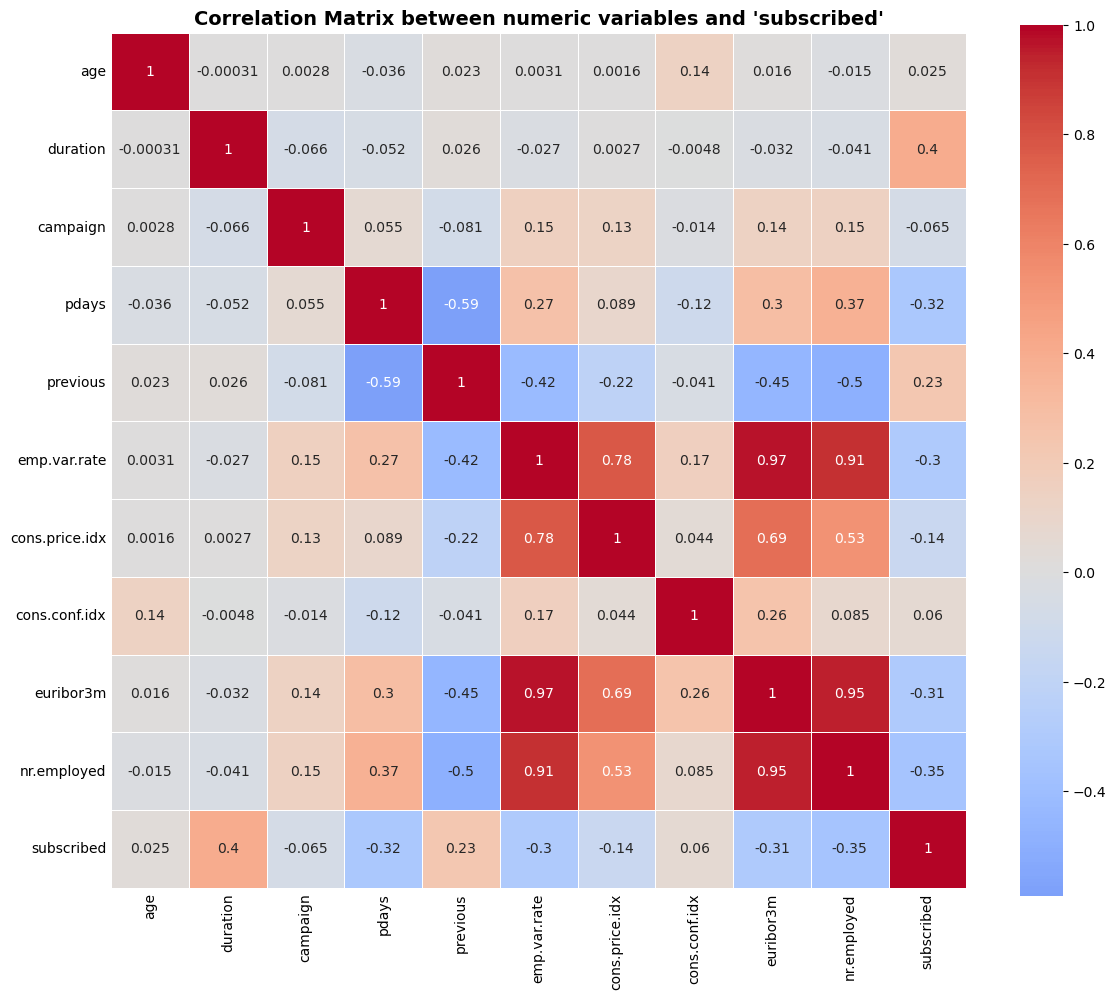

In [ ]:
# 2.3 Linear Correlation between numeric columns and 'subscribed'

import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Merge X and y back into a single Dataframe
corr_df = X.copy()
corr_df['subscribed'] = y

# Step 2: Ensure numeric columns in appropriate format
num_corr_df = corr_df.select_dtypes(include=['int64', 'float64'])

# Step 3: Linear correlation representing numeric variables and 'subscribed'
correlation_matrix = num_corr_df.corr(method='pearson')

plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title("Correlation Matrix between numeric variables and 'subscribed'", fontsize=14, fontweight='bold')
plt.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()


In [7]:
# 3) Problem-Solving Approach Part 

# Experiment on the best parameter settings

# K-Nearest Neighbours 

# Test settings with imbalanced data

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

k_values = [3, 5, 7, 9]
best_f1 = 0
best_k = None

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_processed, y_train)
    predicts = knn.predict(X_val_processed)
    score = f1_score(y_val, predicts)
    print(f"k={k}, F1-score={score:.4f}")

    if score > best_f1:
        best_f1 = score
        best_k = k 
    
print(f"\nBest k: {best_k} with F1-score: {best_f1:.4f}")


k=3, F1-score=0.4745
k=5, F1-score=0.4912
k=7, F1-score=0.4850
k=9, F1-score=0.4710

Best k: 5 with F1-score: 0.4912


In [8]:
# Test settings using balanced data with Random Over Sampler

from imblearn.over_sampling import RandomOverSampler

# Step 1: Balance training set
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train_processed, y_train)

# Step 2: Repeat steps from unbalanced data
k_values = [3, 5, 7, 9]
best_f1 = 0
best_k = None

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_processed, y_train)
    predicts = knn.predict(X_val_processed)
    score = f1_score(y_val, predicts)
    print(f"k={k}, F1-score={score:.4f}")

    if score > best_f1:
        best_f1 = score
        best_k = k 
    
print(f"\nBest k: {best_k} with F1-score: {best_f1:.4f}")

k=3, F1-score=0.4745
k=5, F1-score=0.4912
k=7, F1-score=0.4850
k=9, F1-score=0.4710

Best k: 5 with F1-score: 0.4912


In [9]:
# Test settings with balanced data with SMOTE

from imblearn.over_sampling import SMOTE

# Step 1: Apply SMOTE to preprocessors
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

# Step 2: Repeat steps from unbalanced data
k_values = [3, 5, 7, 9]
best_f1 = 0
best_k = None

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_processed, y_train)
    predicts = knn.predict(X_val_processed)
    score = f1_score(y_val, predicts)
    print(f"k={k}, F1-score={score:.4f}")

    if score > best_f1:
        best_f1 = score
        best_k = k 
    
print(f"\nBest k: {best_k} with F1-score: {best_f1:.4f}")

k=3, F1-score=0.4745
k=5, F1-score=0.4912
k=7, F1-score=0.4850
k=9, F1-score=0.4710

Best k: 5 with F1-score: 0.4912


In [10]:
# Decision Trees

from sklearn.tree import DecisionTreeClassifier

# Test settings with imbalanced data

depths = [3, 5, 7, 10, 15]
best_f1= 0 
best_depth = None

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d, random_state=42)
    dt.fit(X_train_tree_processed, y_train_tree)
    predicts = dt.predict(X_val_tree_processed)
    score = f1_score(y_val_tree, predicts)
    print(f"Depth={d}, F1-score={score:.4f}")

    if score > best_f1:
        best_f1 = score
        best_depth = d

print(f"\nBest depth: {best_depth} with F1 score: {best_f1:.4f}")

Depth=3, F1-score=0.6129
Depth=5, F1-score=0.5925
Depth=7, F1-score=0.5759
Depth=10, F1-score=0.5550
Depth=15, F1-score=0.5211

Best depth: 3 with F1 score: 0.6129


In [11]:
# Test settings with balanced data

depths = [3, 5, 7, 10, 15]
best_f1= 0 
best_depth = None

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d, class_weight='balanced', random_state=42)
    dt.fit(X_train_tree_processed, y_train_tree)
    predicts = dt.predict(X_val_tree_processed)
    score = f1_score(y_val_tree, predicts)
    print(f"Depth={d}, F1-score={score:.4f}")

    if score > best_f1:
        best_f1 = score
        best_depth = d

print(f"\nBest depth: {best_depth} with F1 score: {best_f1:.4f}")

Depth=3, F1-score=0.5142
Depth=5, F1-score=0.5622
Depth=7, F1-score=0.5640
Depth=10, F1-score=0.5726
Depth=15, F1-score=0.5623

Best depth: 10 with F1 score: 0.5726


In [12]:
# Random Forest

# Test settings with imbalanced data

from sklearn.ensemble import RandomForestClassifier

n_estimators = [50, 100, 150]
max_depths = [5, 10, 15]
best_f1 = -1
best_forest = None

for n in n_estimators:
    for d in max_depths:
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42)
        rf.fit(X_train_tree_processed, y_train_tree)
        predicts = rf.predict(X_val_tree_processed)
        score = f1_score(y_val_tree, predicts)
        print(f"N estimators={n}, max_depth={d}, F1-score{score:.4f}")

        if score > best_f1:
            best_f1 = score
            best_forest = (n, d)


print(f"\nBest model: n_estimators={best_forest[0]}, max_depth={best_forest[1]}, with F1 score: {best_f1:.4f}")

# The dataset was heavily imbalanced by leaning towards non-subscribed attribute, thus we need to balance first
# print(y_val_tree.value_counts(normalize=True))

N estimators=50, max_depth=5, F1-score0.3021
N estimators=50, max_depth=10, F1-score0.4331
N estimators=50, max_depth=15, F1-score0.5085
N estimators=100, max_depth=5, F1-score0.3045
N estimators=100, max_depth=10, F1-score0.4357
N estimators=100, max_depth=15, F1-score0.5032
N estimators=150, max_depth=5, F1-score0.3073
N estimators=150, max_depth=10, F1-score0.4289
N estimators=150, max_depth=15, F1-score0.4960

Best model: n_estimators=50, max_depth=15, with F1 score: 0.5085


In [13]:
# Test settings with balanced data

from sklearn.ensemble import RandomForestClassifier

n_estimators = [50, 100, 150]
max_depths = [5, 10, 15]
best_f1 = -1
best_forest = None

for n in n_estimators:
    for d in max_depths:
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, class_weight='balanced', random_state=42)
        rf.fit(X_train_tree_processed, y_train_tree)
        predicts = rf.predict(X_val_tree_processed)
        score = f1_score(y_val_tree, predicts)
        print(f"N estimators={n}, max_depth={d}, F1-score{score:.4f}")

        if score > best_f1:
            best_f1 = score
            best_forest = (n, d)

print(f"\nBest model: n_estimators={best_forest[0]}, max_depth={best_forest[1]}, with F1 score: {best_f1:.4f}")


N estimators=50, max_depth=5, F1-score0.5286
N estimators=50, max_depth=10, F1-score0.5914
N estimators=50, max_depth=15, F1-score0.6184
N estimators=100, max_depth=5, F1-score0.5255
N estimators=100, max_depth=10, F1-score0.5955
N estimators=100, max_depth=15, F1-score0.6202
N estimators=150, max_depth=5, F1-score0.5250
N estimators=150, max_depth=10, F1-score0.5939
N estimators=150, max_depth=15, F1-score0.6212

Best model: n_estimators=150, max_depth=15, with F1 score: 0.6212


In [14]:
# Support Vector Machine 

# Test settings with imbalanced data

from sklearn.svm import SVC

kernels = ['linear', 'rbf']
C_values = [0.1, 1, 10]
best_f1 = -1
best_setting = None

for kernel in kernels:
    for C in C_values:
        svm = SVC(kernel=kernel, C=C, random_state=42)
        svm.fit(X_train_processed, y_train)
        predicts = svm.predict(X_val_processed)
        score = f1_score(y_val, predicts)
        print(f"Kernel={kernel}, C={C}, F1-score={score:.4f}")

        if score > best_f1:
            best_f1 = score 
            best_setting = (kernel, C)

print(f"\nBest SVM: Kernel={best_setting[0]}, C={best_setting[1]}, with F1 score: {best_f1:.4f}")

Kernel=linear, C=0.1, F1-score=0.4352
Kernel=linear, C=1, F1-score=0.4273
Kernel=linear, C=10, F1-score=0.4273
Kernel=rbf, C=0.1, F1-score=0.4333
Kernel=rbf, C=1, F1-score=0.5071
Kernel=rbf, C=10, F1-score=0.5284

Best SVM: Kernel=rbf, C=10, with F1 score: 0.5284


In [15]:
# Test settings with balanced data

kernels = ['linear', 'rbf']
C_values = [0.1, 1, 10]
best_f1 = -1
best_setting = None

for kernel in kernels:
    for C in C_values:
        svm = SVC(kernel=kernel, C=C, class_weight='balanced', random_state=42)
        svm.fit(X_train_processed, y_train)
        predicts = svm.predict(X_val_processed)
        score = f1_score(y_val, predicts)
        print(f"Kernel={kernel}, C={C}, F1-score={score:.4f}")

        if score > best_f1:
            best_f1 = score 
            best_setting = (kernel, C)

print(f"\nBest SVM: Kernel={best_setting[0]}, C={best_setting[1]}, with F1 score: {best_f1:.4f}")

Kernel=linear, C=0.1, F1-score=0.5624
Kernel=linear, C=1, F1-score=0.5640
Kernel=linear, C=10, F1-score=0.5639
Kernel=rbf, C=0.1, F1-score=0.5517
Kernel=rbf, C=1, F1-score=0.5770
Kernel=rbf, C=10, F1-score=0.5555

Best SVM: Kernel=rbf, C=1, with F1 score: 0.5770


In [ ]:
# Neural Network

# Test settings using imbalanced data

from sklearn.neural_network import MLPClassifier

best_f1 = 0
best_setting = None

for layers in layer_sizes: 
    for alpha in alphas:
        nn = MLPClassifier(
            hidden_layer_sizes=layers, 
            alpha=alpha, 
            max_iter=1000,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10,
            random_state=42)
        nn.fit(X_train_processed, y_train)
        predicts = nn.predict(X_val_processed)
        score = f1_score(y_val, predicts)
        print(f"Layers={layers}, Alpha={alpha}, F1-score={score:.4f}")

        if score > best_f1:
            best_f1 = score 
            best_setting = (layers, alpha)

print(f"\nBest NN: Layers={best_setting[0]}, Alpha={best_setting[1]}, with F1 score: {best_f1:.4f}")

Layers=(50,), Alpha=0.0001, F1-score=0.5677
Layers=(50,), Alpha=0.001, F1-score=0.5504
Layers=(100,), Alpha=0.0001, F1-score=0.5614
Layers=(100,), Alpha=0.001, F1-score=0.5647
Layers=(100, 50), Alpha=0.0001, F1-score=0.5822
Layers=(100, 50), Alpha=0.001, F1-score=0.5804

Best NN: Layers=(100, 50), Alpha=0.0001, with F1 score: 0.5822


In [17]:
# Tuning for the best parameter settings using balanced data

from imblearn.over_sampling import RandomOverSampler

# Step 1: Balance training set
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train_processed, y_train)

# Step 2: Repeat of the steps from above
layer_sizes = [(50,), (100,), (100, 50)]
alphas = [0.0001, 0.001]
best_f1 = 0
best_setting = None

for layers in layer_sizes: 
    for alpha in alphas:
        nn = MLPClassifier(
            hidden_layer_sizes=layers, 
            alpha=alpha, 
            max_iter=1000,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10,
            random_state=42)
        nn.fit(X_train_balanced, y_train_balanced)
        predicts = nn.predict(X_val_processed)
        score = f1_score(y_val, predicts)
        print(f"Layers={layers}, Alpha={alpha}, F1-score={score:.4f}")

        if score > best_f1:
            best_f1 = score 
            best_setting = (layers, alpha)

print(f"\nBest Balanced NN: Layers={best_setting[0]}, Alpha={best_setting[1]}, with F1 score: {best_f1:.4f}")


Layers=(50,), Alpha=0.0001, F1-score=0.5775
Layers=(50,), Alpha=0.001, F1-score=0.5806
Layers=(100,), Alpha=0.0001, F1-score=0.5696
Layers=(100,), Alpha=0.001, F1-score=0.5759
Layers=(100, 50), Alpha=0.0001, F1-score=0.5541
Layers=(100, 50), Alpha=0.001, F1-score=0.5334

Best Balanced NN: Layers=(50,), Alpha=0.001, with F1 score: 0.5806


In [18]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

layer_sizes = [(50,), (100,), (100, 50)]
alphas = [0.0001, 0.001]
best_f1 = 0
best_setting = None

for layers in layer_sizes: 
    for alpha in alphas:
        nn = MLPClassifier(
            hidden_layer_sizes=layers, 
            alpha=alpha, 
            max_iter=1000,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10,
            random_state=42)
        nn.fit(X_train_smote, y_train_smote)
        predicts = nn.predict(X_val_processed)
        score = f1_score(y_val, predicts)
        print(f"Layers={layers}, Alpha={alpha}, F1-score={score:.4f}")

        if score > best_f1:
            best_f1 = score 
            best_setting = (layers, alpha)

print(f"\nBest Balanced NN: Layers={best_setting[0]}, Alpha={best_setting[1]}, with F1 score: {best_f1:.4f}")


Layers=(50,), Alpha=0.0001, F1-score=0.5863
Layers=(50,), Alpha=0.001, F1-score=0.5665
Layers=(100,), Alpha=0.0001, F1-score=0.5588
Layers=(100,), Alpha=0.001, F1-score=0.5757
Layers=(100, 50), Alpha=0.0001, F1-score=0.5582
Layers=(100, 50), Alpha=0.001, F1-score=0.5289

Best Balanced NN: Layers=(50,), Alpha=0.0001, with F1 score: 0.5863


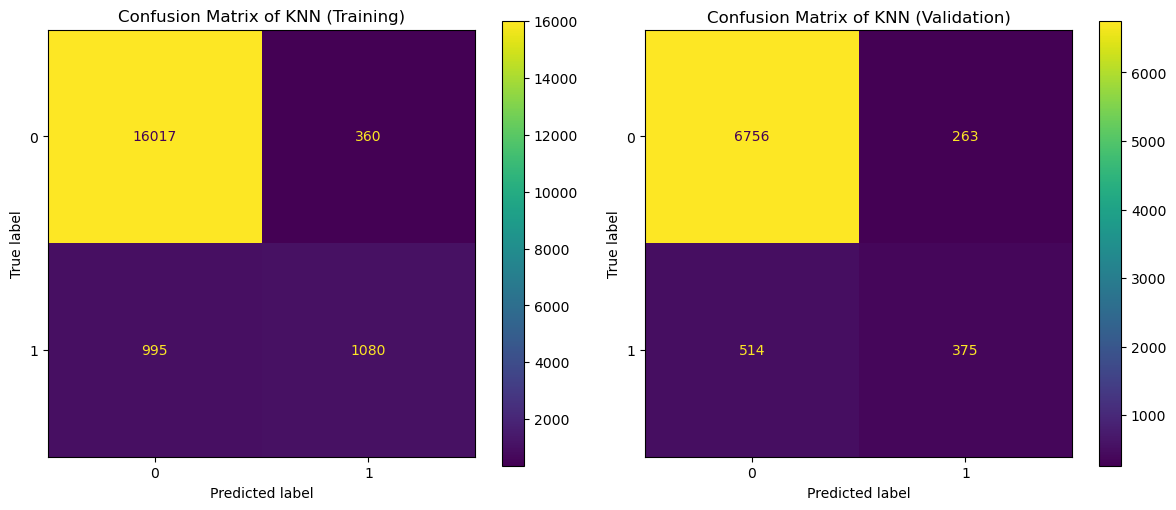

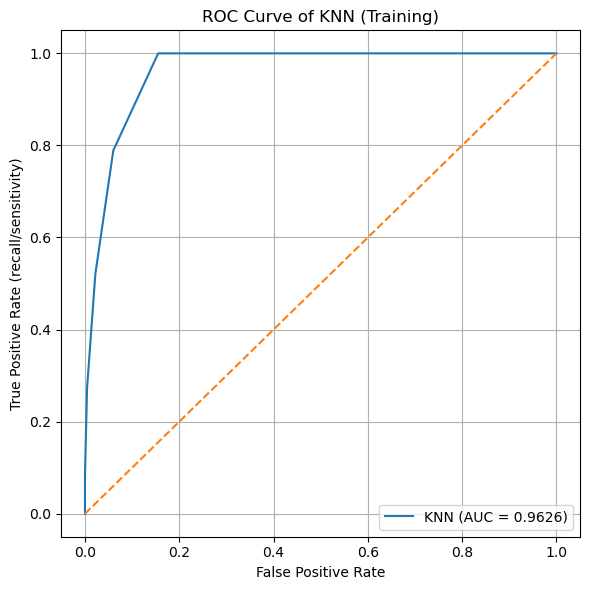

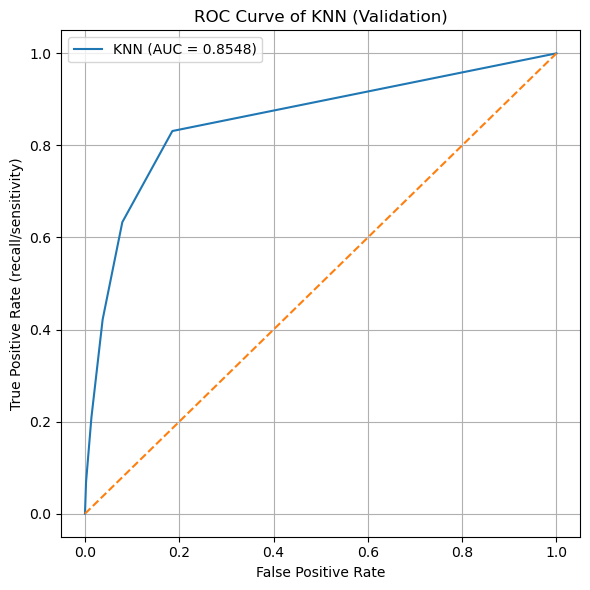

=== Classification Metrics for KNN (Training) ===
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     16377
           1       0.75      0.52      0.61      2075

    accuracy                           0.93     18452
   macro avg       0.85      0.75      0.79     18452
weighted avg       0.92      0.93      0.92     18452

=== Classification Metrics for KNN (Validation) ===
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7019
           1       0.59      0.42      0.49       889

    accuracy                           0.90      7908
   macro avg       0.76      0.69      0.72      7908
weighted avg       0.89      0.90      0.89      7908



In [19]:
# 4) Problem-Solving Approach Part 2

# 4.1 K-Nearest Neighbour

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc

# Step 1: Build classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_processed, y_train)

# Step 2: Predict on training and validation
y_train_predict = knn.predict(X_train_processed)
y_val_predict = knn.predict(X_val_processed)

# Step 3: Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_predict, ax=ax[0])
ax[0].set_title("Confusion Matrix of KNN (Training)")

ConfusionMatrixDisplay.from_predictions(y_val, y_val_predict, ax=ax[1])
ax[1].set_title("Confusion Matrix of KNN (Validation)")
plt.tight_layout()
plt.show()

# Step 4: Plot ROC curve
# For training:
y_train_prob = knn.predict_proba(X_train_processed)[:, 1]
fpr, tpr, _ = roc_curve(y_train, y_train_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"KNN (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall/sensitivity)")
plt.title("ROC Curve of KNN (Training)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# For validation:
y_val_prob = knn.predict_proba(X_val_processed)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"KNN (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall/sensitivity)")
plt.title("ROC Curve of KNN (Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Performance Metrics
print("=== Classification Metrics for KNN (Training) ===")
print(classification_report(y_train, y_train_predict))
print("=== Classification Metrics for KNN (Validation) ===")
print(classification_report(y_val, y_val_predict))

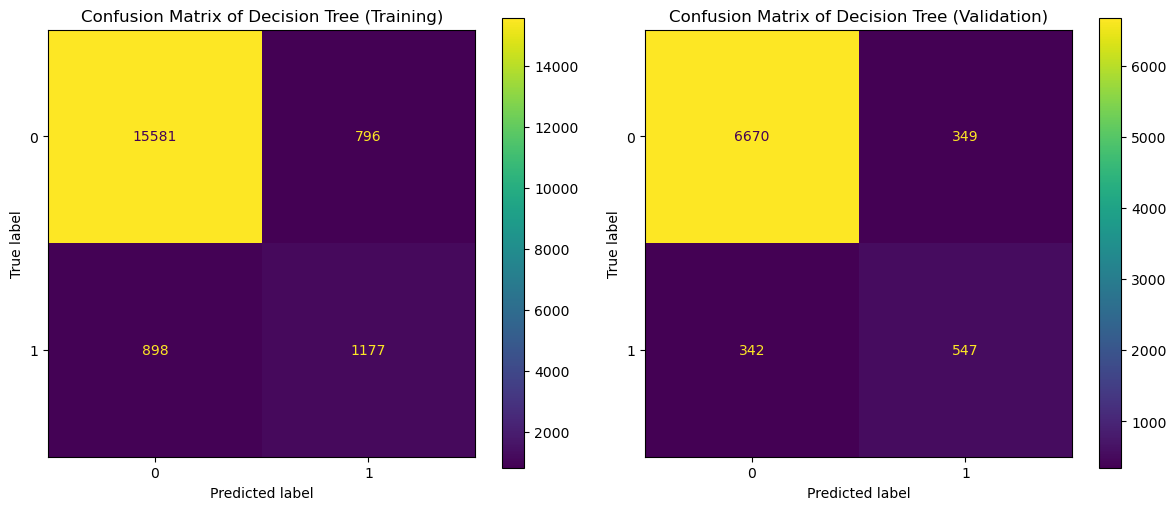

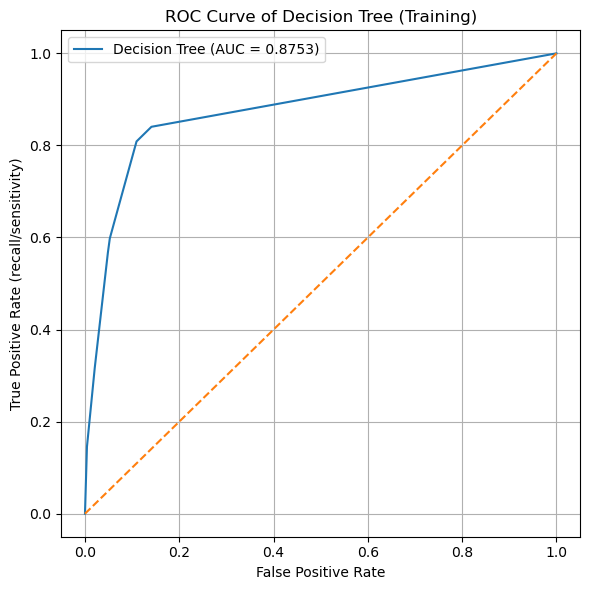

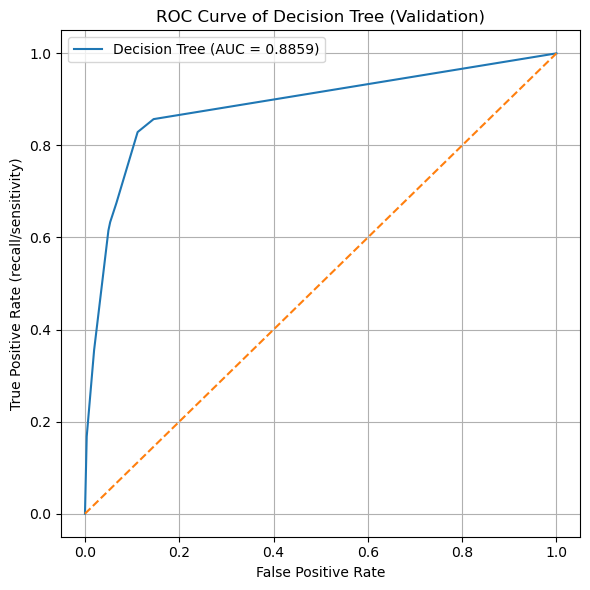

=== Classification Metrics for Decision Tree (Training) ===
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     16377
           1       0.60      0.57      0.58      2075

    accuracy                           0.91     18452
   macro avg       0.77      0.76      0.76     18452
weighted avg       0.91      0.91      0.91     18452

=== Classification Metrics for Decision Tree (Validation) ===
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7019
           1       0.61      0.62      0.61       889

    accuracy                           0.91      7908
   macro avg       0.78      0.78      0.78      7908
weighted avg       0.91      0.91      0.91      7908



In [ ]:
# 4.2 Decision Trees 

# for col in cat_cols_trees:
#     print(f"{col}: {ida_data_m[col].nunique()}")

# Step 1: Build Classifier 
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train_tree_processed, y_train_tree)

# Step 2: Predict on training and validation
y_train_predict = dt.predict(X_train_tree_processed)
y_val_predict = dt.predict(X_val_tree_processed)

# Step 3: Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ConfusionMatrixDisplay.from_predictions(y_train_tree, y_train_predict, ax=ax[0])
ax[0].set_title("Confusion Matrix of Decision Tree (Training)")

ConfusionMatrixDisplay.from_predictions(y_val_tree, y_val_predict, ax=ax[1])
ax[1].set_title("Confusion Matrix of Decision Tree (Validation)")
plt.tight_layout()
plt.show()

# Step 4: Plot ROC curve
# For training:
y_train_prob = dt.predict_proba(X_train_tree_processed)[:, 1]
fpr, tpr, _ = roc_curve(y_train_tree, y_train_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Decision Tree (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall/sensitivity)")
plt.title("ROC Curve of Decision Tree (Training)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# For validation:
y_val_prob = dt.predict_proba(X_val_tree_processed)[:, 1]
fpr, tpr, _ = roc_curve(y_val_tree, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Decision Tree (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall/sensitivity)")
plt.title("ROC Curve of Decision Tree (Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Performance Metrics
print("=== Classification Metrics for Decision Tree (Training) ===")
print(classification_report(y_train_tree, y_train_predict))
print("=== Classification Metrics for Decision Tree (Validation) ===")
print(classification_report(y_val_tree, y_val_predict))

#Note: even though f1-score of depth=3 is the highest, depth=5 is most ideal based on ROC

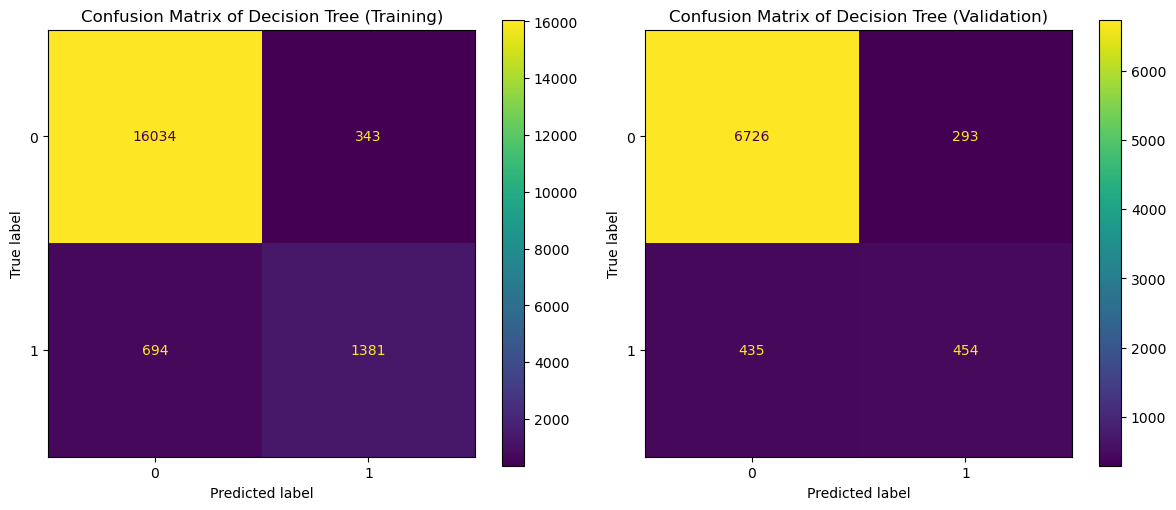

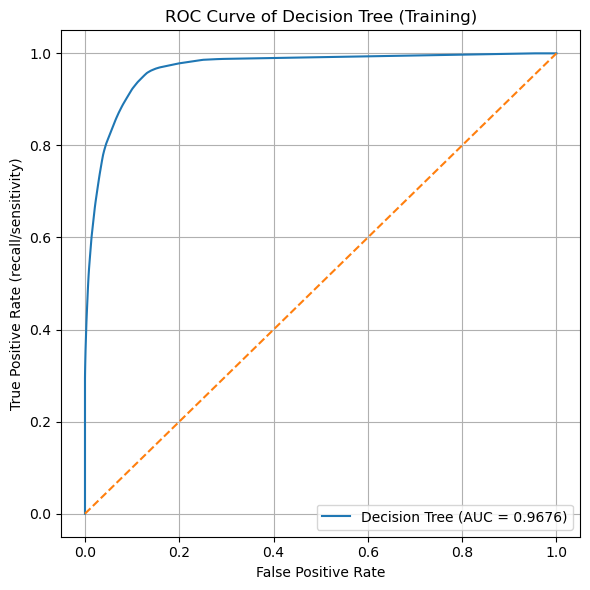

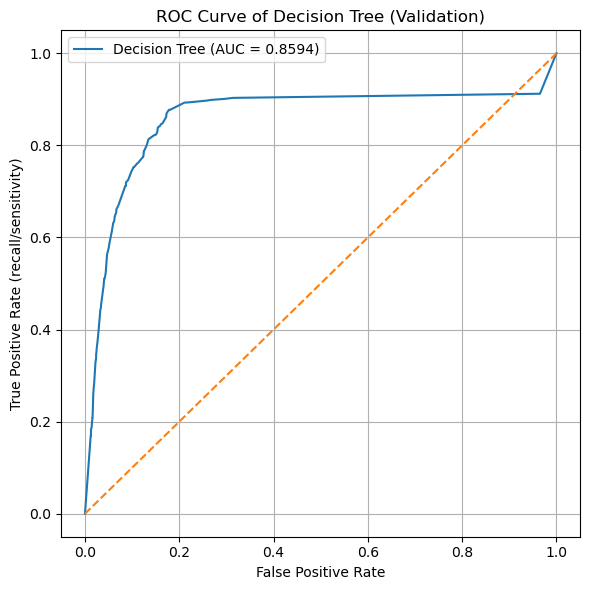

=== Classification Metrics for Decision Tree (Training) ===
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     16377
           1       0.80      0.67      0.73      2075

    accuracy                           0.94     18452
   macro avg       0.88      0.82      0.85     18452
weighted avg       0.94      0.94      0.94     18452

=== Classification Metrics for Decision Tree (Validation) ===
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7019
           1       0.61      0.51      0.56       889

    accuracy                           0.91      7908
   macro avg       0.77      0.73      0.75      7908
weighted avg       0.90      0.91      0.90      7908



In [21]:
# 4.2 Decision Trees - different max_depth

# Step 1: Build Classifier 
dt = DecisionTreeClassifier(max_depth=10, random_state=42) # new setting
dt.fit(X_train_tree_processed, y_train_tree)

# Step 2: Predict on training and validation
y_train_predict = dt.predict(X_train_tree_processed)
y_val_predict = dt.predict(X_val_tree_processed)

# Step 3: Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ConfusionMatrixDisplay.from_predictions(y_train_tree, y_train_predict, ax=ax[0])
ax[0].set_title("Confusion Matrix of Decision Tree (Training)")

ConfusionMatrixDisplay.from_predictions(y_val_tree, y_val_predict, ax=ax[1])
ax[1].set_title("Confusion Matrix of Decision Tree (Validation)")
plt.tight_layout()
plt.show()

# Step 4: Plot ROC curve
# For training:
y_train_prob = dt.predict_proba(X_train_tree_processed)[:, 1]
fpr, tpr, _ = roc_curve(y_train_tree, y_train_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Decision Tree (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall/sensitivity)")
plt.title("ROC Curve of Decision Tree (Training)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# For validation:
y_val_prob = dt.predict_proba(X_val_tree_processed)[:, 1]
fpr, tpr, _ = roc_curve(y_val_tree, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Decision Tree (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall/sensitivity)")
plt.title("ROC Curve of Decision Tree (Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Performance Metrics
print("=== Classification Metrics for Decision Tree (Training) ===")
print(classification_report(y_train_tree, y_train_predict))
print("=== Classification Metrics for Decision Tree (Validation) ===")
print(classification_report(y_val_tree, y_val_predict))

#Note: even though f1-score of depth=3 is the highest, depth=5 is most ideal based on ROC

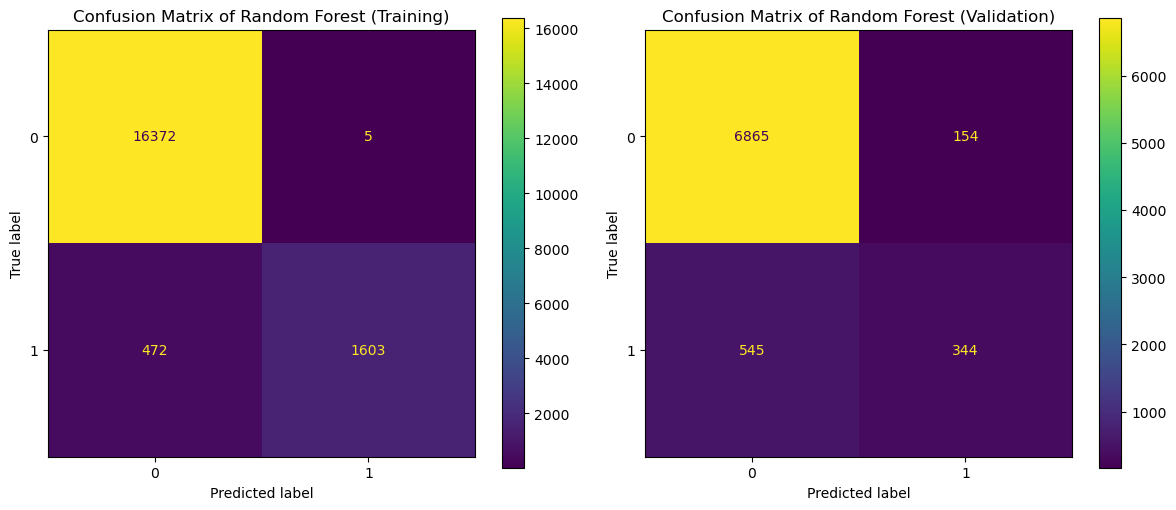

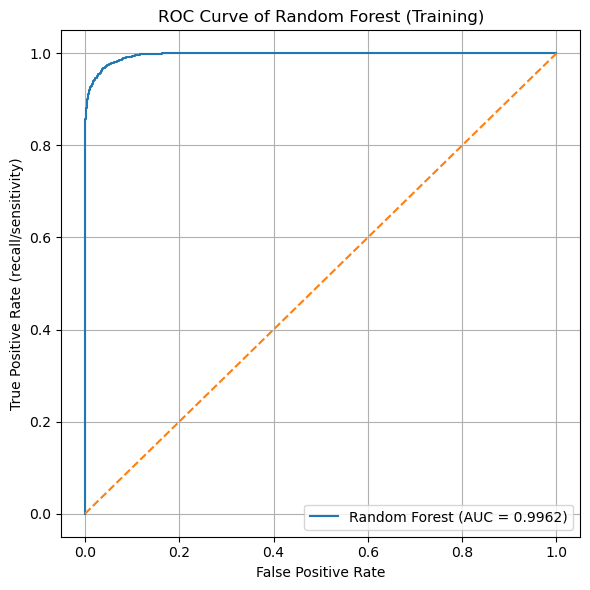

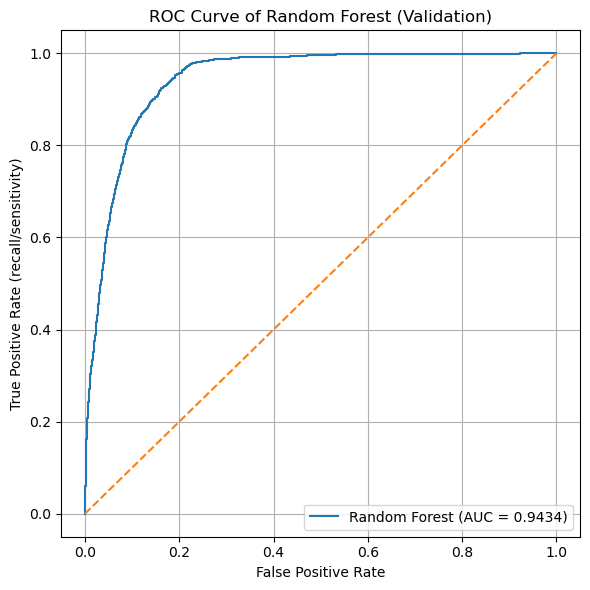

=== Classification Metrics for Random Forest (Training) ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     16377
           1       1.00      0.77      0.87      2075

    accuracy                           0.97     18452
   macro avg       0.98      0.89      0.93     18452
weighted avg       0.97      0.97      0.97     18452

=== Classification Metrics for Random Forest (Validation) ===
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7019
           1       0.69      0.39      0.50       889

    accuracy                           0.91      7908
   macro avg       0.81      0.68      0.72      7908
weighted avg       0.90      0.91      0.90      7908



In [22]:
# 4.3 Random Forest

# Step 1: Build Classifier 
rf = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=42) 
rf.fit(X_train_tree_processed, y_train_tree)

# Step 2: Predict on training and validation
y_train_predict = rf.predict(X_train_tree_processed)
y_val_predict = rf.predict(X_val_tree_processed)

# Step 3: Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ConfusionMatrixDisplay.from_predictions(y_train_tree, y_train_predict, ax=ax[0])
ax[0].set_title("Confusion Matrix of Random Forest (Training)")

ConfusionMatrixDisplay.from_predictions(y_val_tree, y_val_predict, ax=ax[1])
ax[1].set_title("Confusion Matrix of Random Forest (Validation)")
plt.tight_layout()
plt.show()

# Step 4: Plot ROC curve
# For training:
y_train_prob = rf.predict_proba(X_train_tree_processed)[:, 1]
fpr, tpr, _ = roc_curve(y_train_tree, y_train_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall/sensitivity)")
plt.title("ROC Curve of Random Forest (Training)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# For validation:
y_val_prob = rf.predict_proba(X_val_tree_processed)[:, 1]
fpr, tpr, _ = roc_curve(y_val_tree, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall/sensitivity)")
plt.title("ROC Curve of Random Forest (Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Performance Metrics
print("=== Classification Metrics for Random Forest (Training) ===")
print(classification_report(y_train_tree, y_train_predict))
print("=== Classification Metrics for Random Forest (Validation) ===")
print(classification_report(y_val_tree, y_val_predict))


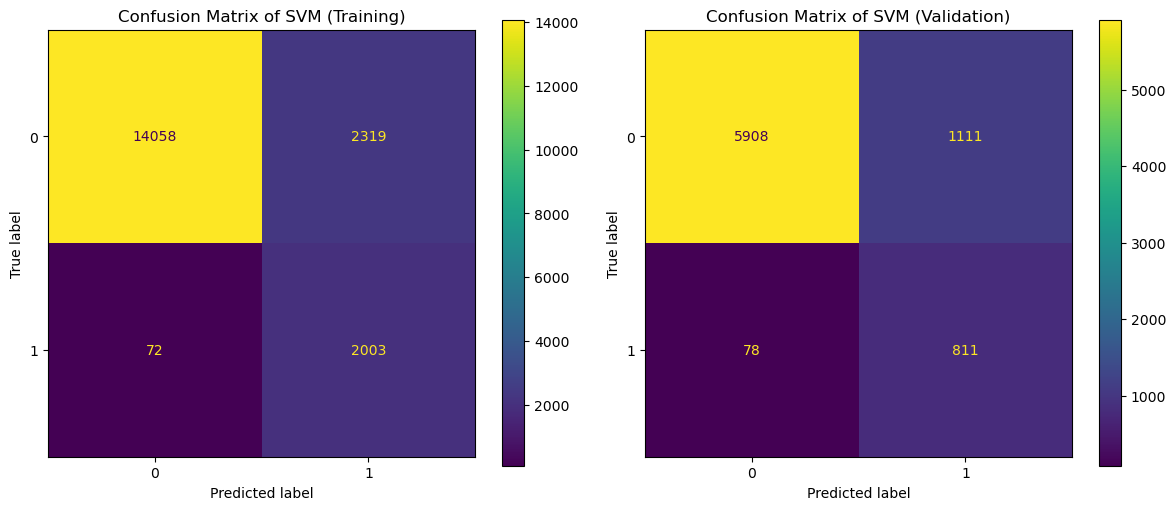

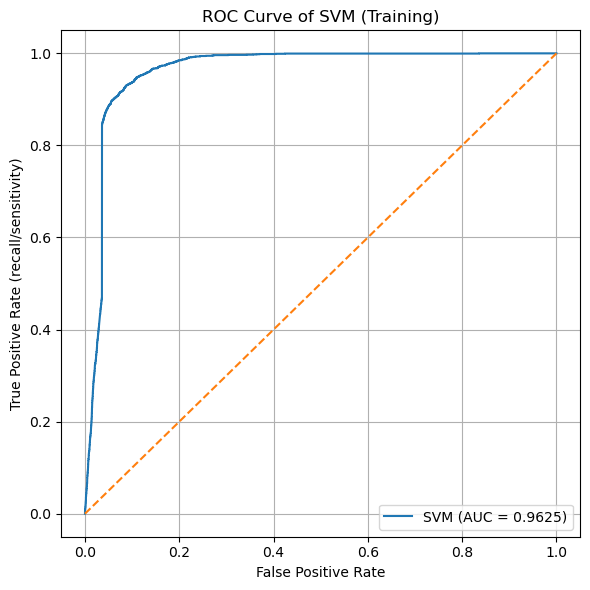

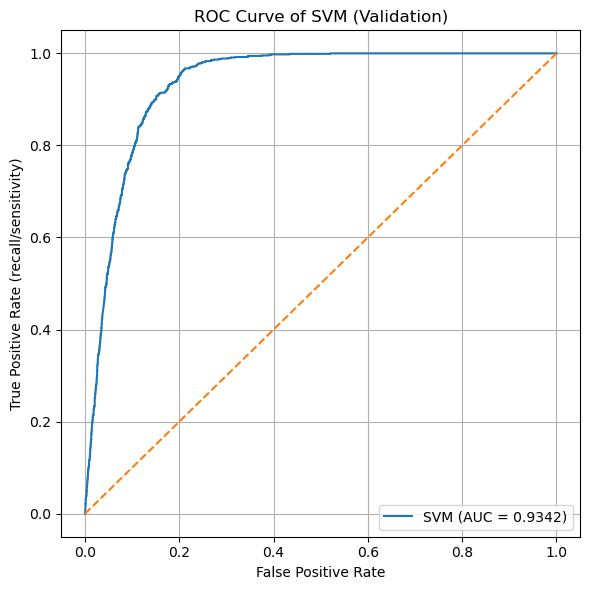

=== Classification Metrics for SVM (Training) ===
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     16377
           1       0.46      0.97      0.63      2075

    accuracy                           0.87     18452
   macro avg       0.73      0.91      0.77     18452
weighted avg       0.94      0.87      0.89     18452

=== Classification Metrics for SVM (Validation) ===
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      7019
           1       0.42      0.91      0.58       889

    accuracy                           0.85      7908
   macro avg       0.70      0.88      0.74      7908
weighted avg       0.92      0.85      0.87      7908



In [23]:
# 4.4 Support Vector Machine

# Step 1: Build Classifier 
svm = SVC(kernel='rbf', C=1, probability=True, class_weight='balanced', random_state=42) 
svm.fit(X_train_processed, y_train)

# Step 2: Predict on training and validation
y_train_predict = svm.predict(X_train_processed)
y_val_predict = svm.predict(X_val_processed)

# Step 3: Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_predict, ax=ax[0])
ax[0].set_title("Confusion Matrix of SVM (Training)")

ConfusionMatrixDisplay.from_predictions(y_val, y_val_predict, ax=ax[1])
ax[1].set_title("Confusion Matrix of SVM (Validation)")
plt.tight_layout()
plt.show()

# Step 4: Plot ROC curve
# For training:
y_train_prob = svm.predict_proba(X_train_processed)[:, 1]
fpr, tpr, _ = roc_curve(y_train, y_train_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall/sensitivity)")
plt.title("ROC Curve of SVM (Training)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# For validation:
y_val_prob = svm.predict_proba(X_val_processed)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall/sensitivity)")
plt.title("ROC Curve of SVM (Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Performance Metrics
print("=== Classification Metrics for SVM (Training) ===")
print(classification_report(y_train, y_train_predict))
print("=== Classification Metrics for SVM (Validation) ===")
print(classification_report(y_val, y_val_predict))


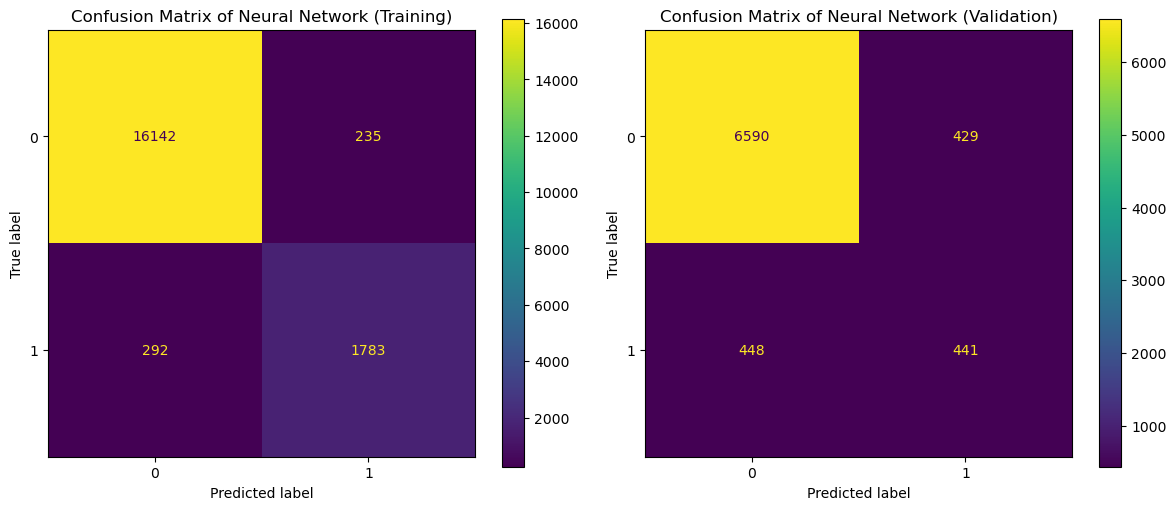

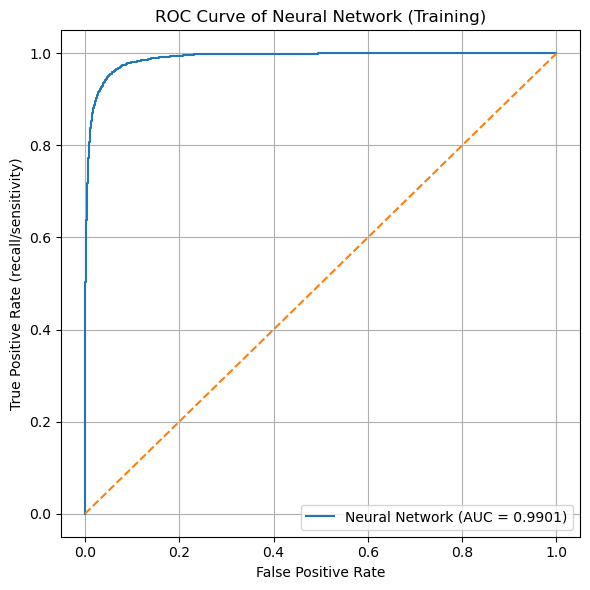

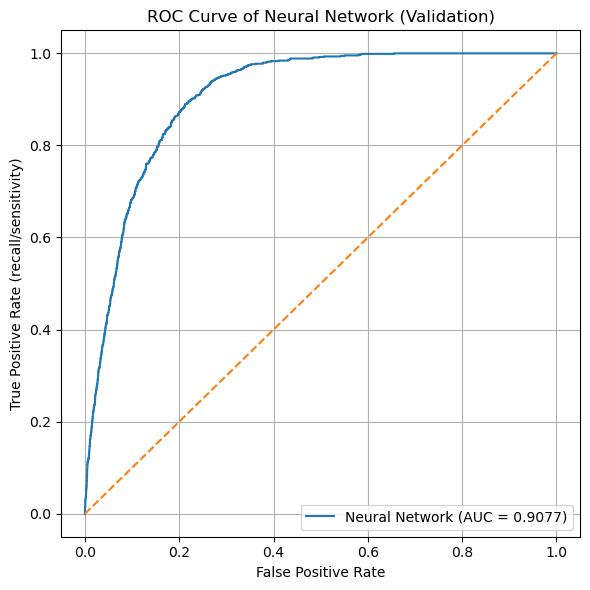

=== Classification Metrics for Neural Network (Training) ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     16377
           1       0.88      0.86      0.87      2075

    accuracy                           0.97     18452
   macro avg       0.93      0.92      0.93     18452
weighted avg       0.97      0.97      0.97     18452

=== Classification Metrics for Neural Network (Validation) ===
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7019
           1       0.51      0.50      0.50       889

    accuracy                           0.89      7908
   macro avg       0.72      0.72      0.72      7908
weighted avg       0.89      0.89      0.89      7908



In [24]:
# 4.5 Neural Network

# Step 1: Build Classifier 
nn = MLPClassifier(hidden_layer_sizes=(50, ), alpha=0.0001, max_iter=1000, random_state=42) 
nn.fit(X_train_processed, y_train)

# Step 2: Predict on training and validation
y_train_predict = nn.predict(X_train_processed)
y_val_predict = nn.predict(X_val_processed)

# Step 3: Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_predict, ax=ax[0])
ax[0].set_title("Confusion Matrix of Neural Network (Training)")

ConfusionMatrixDisplay.from_predictions(y_val, y_val_predict, ax=ax[1])
ax[1].set_title("Confusion Matrix of Neural Network (Validation)")
plt.tight_layout()
plt.show()

# Step 4: Plot ROC curve
# For training: 
y_train_prob = nn.predict_proba(X_train_processed)[:, 1]
fpr, tpr, _ = roc_curve(y_train, y_train_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Neural Network (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall/sensitivity)")
plt.title("ROC Curve of Neural Network (Training)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# For validation:
y_val_prob = nn.predict_proba(X_val_processed)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Neural Network (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall/sensitivity)")
plt.title("ROC Curve of Neural Network (Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Performance Metrics
print("=== Classification Metrics for Neural Network (Training) ===")
print(classification_report(y_train, y_train_predict))
print("=== Classification Metrics for Neural Network (Validation) ===")
print(classification_report(y_val, y_val_predict))


In [25]:
# 4.6 Testing DT with Unknown Dataset (Building Predictive Model)

# K-Nearest Neighbour

# Step 1: Predict all classifiers
knn_preds_u = knn.predict(X_unknown_processed)

# Step 2: Combine predictive models to Dataframe
kaggle_submission = pd.DataFrame({
    'row ID': ida_data_u['row ID'],
    'KNN': knn_preds_u,
})

# Step 3: Export CSV for Kaggle Competition
kaggle_submission.to_csv("UTS_31250_IDA_13289576_KNN_Submission_.csv", index=False)

# # count subscribed vs non-subscribed
# print(ida_data_m['subscribed'].value_counts())

In [26]:
# Decision Tree

# Step 1: Predict all classifiers
dt_preds_u = dt.predict(X_unknown_tree_processed)

# Step 2: Combine predictive models to Dataframe
kaggle_submission = pd.DataFrame({
    'row ID': ida_data_u['row ID'],
    'Decision Tree': dt_preds_u
})

# Step 3: Export CSV for Kaggle Competition
kaggle_submission.to_csv("UTS_31250_IDA_13289576_DT_Submission_.csv", index=False)

In [27]:
# Random Forest

# Step 1: Predict all classifiers
rf_preds_u = rf.predict(X_unknown_tree_processed)

# Step 2: Combine predictive models to Dataframe
kaggle_submission = pd.DataFrame({
    'row ID': ida_data_u['row ID'],
    'Random Forest': rf_preds_u,
})

# Step 3: Export CSV for Kaggle Competition
kaggle_submission.to_csv("UTS_31250_IDA_13289576_RF_Submission_.csv", index=False)

In [28]:
# Support Vector Machine

# Step 1: Predict all classifiers
svm_preds_u = svm.predict(X_unknown_processed)

# Step 2: Combine predictive models to Dataframe
kaggle_submission = pd.DataFrame({
    'row ID': ida_data_u['row ID'],
    'SVM': svm_preds_u,
})

# Step 3: Export CSV for Kaggle Competition
kaggle_submission.to_csv("UTS_31250_IDA_13289576_SVM_Submission_.csv", index=False)

In [29]:
# Neural Network

# Step 1: Predict all classifiers
nn_preds_u = nn.predict(X_unknown_processed)

# Step 2: Combine predictive models to Dataframe
kaggle_submission = pd.DataFrame({
    'row ID': ida_data_u['row ID'],
    'Neural Network': nn_preds_u,
})

# Step 3: Export CSV for Kaggle Competition
kaggle_submission.to_csv("UTS_31250_IDA_13289576_NN_Submission_.csv", index=False)